<a href="https://colab.research.google.com/github/naseembabu/Speech-Classification/blob/main/emotions_classification_cqcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import librosa
path = "/content/merged_0001.wav"
samples, sr = librosa.load(path)

In [ ]:
from IPython.display import Audio
Audio(path)

In [ ]:
print(samples)

[ 0.          0.          0.         ... -0.00703231 -0.00880595
 -0.00821524]


In [ ]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
from sklearn.model_selection import KFold
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPool1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, concatenate, add
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_fscore_support
from keras.models import Model
from keras import backend as K
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers

In [ ]:
df = pd.read_json("/content/drive/MyDrive/emotions_cqcc01_json.json")

In [ ]:
df['emotions'] = df['emotions'].astype(str) 

In [ ]:
df['emotions']

0       2
1       2
2       2
3       2
4       2
       ..
2813    1
2814    1
2815    1
2816    1
2817    1
Name: emotions, Length: 2818, dtype: object

In [ ]:
df['emotions'] = df['emotions'].replace(str(7),"zero")
df['emotions'] = df['emotions'].replace(str(1),"one")
df['emotions'] = df['emotions'].replace(str(2),"two")
df['emotions'] = df['emotions'].replace(str(3),"three")
df['emotions'] = df['emotions'].replace(str(4),"four")
df['emotions'] = df['emotions'].replace(str(5),"five")
df['emotions'] = df['emotions'].replace(str(6),"six")

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(df['feature'].tolist())
y=np.array(df['emotions'].tolist())

In [ ]:
X.shape

(2818, 40)

In [ ]:
X = np.expand_dims(X, 1)

In [ ]:
X.shape

(2818, 1, 40)

In [ ]:
y.shape

(2818,)

In [ ]:
### Label Encoding
y=np.array(pd.get_dummies(y))

In [ ]:
y[200]

array([0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [ ]:
y.shape

(2818, 7)

In [ ]:

### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self._trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        
        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
model = Sequential()

# 2 LSTM layers
audio_input = Input(shape=(1, 40, ))
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(audio_input)
attn_layer = AttLayer(100)(lstm_layer)
dense1 = Dense(64, activation='relu')(attn_layer)
#model.add(keras.layers.Dropout(0.3))
output1 = Dense(7, activation='softmax')(dense1)
model = Model(inputs = audio_input, outputs = output1)

model

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 40)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 128)            53760     
_________________________________________________________________
att_layer (AttLayer)         (None, 128)               13000     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 75,471
Trainable params: 75,471
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:

## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()


history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
50/50 [==============================] - 5s 21ms/step - loss: 1.6841 - accuracy: 0.4192 - val_loss: 1.2370 - val_accuracy: 0.6810
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 0.9533 - accuracy: 0.7571 - val_loss: 0.6533 - val_accuracy: 0.8380
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 0.5103 - accuracy: 0.8782 - val_loss: 0.3915 - val_accuracy: 0.8937
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 0.3144 - accuracy: 0.9226 - val_loss: 0.2423 - val_accuracy: 0.9494
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 0.2084 - accuracy: 0.9531 - val_loss: 0.1791 - val_accuracy: 0.9595
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.1529 - accuracy: 0.9677 - val_loss: 0.1463 - val_accuracy: 0.9620
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.1163 - accuracy: 0.9721 - val_loss: 0.1226 - val_accuracy: 0.9494
Epoch 8/100


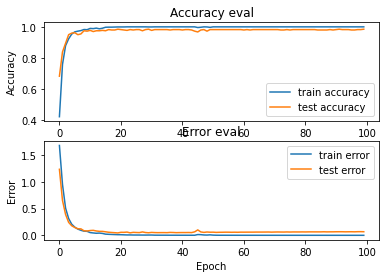

27/27 - 0s - loss: 0.0378 - accuracy: 0.9905

Test accuracy: 0.9905437231063843


In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)